In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 1: Create an imbalanced binary classification dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=2, n_redundant=8, 
                           weights=[0.9, 0.1], flip_y=0, random_state=42)

np.unique(y, return_counts=True)

(array([0, 1]), array([900, 100]))

In [3]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Handle class imbalance

In [4]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)
np.unique(y_train_res, return_counts=True)

(array([0, 1]), array([619, 619]))

# Track Experiments

In [5]:
models = [
    (
        "Logistic Regression", 

        
        {"C": 1, "solver": 'lbfgs'},
        LogisticRegression(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "Random Forest", 
        {"n_estimators": 30, "max_depth": 3},
        RandomForestClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "XGBClassifier",
        {"use_label_encoder": False, "eval_metric": 'logloss'},
        XGBClassifier(), 
        (X_train, y_train),
        (X_test, y_test)
    ),
    (
        "XGBClassifier With SMOTE",
        {"use_label_encoder": False, "eval_metric": 'logloss'},
        XGBClassifier(), 
        (X_train_res, y_train_res),
        (X_test, y_test)
    )
]

In [6]:
reports = []

for model_name, params, model, train_set, test_set in models:
    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

In [9]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost

In [10]:
# Initialize MLflow
mlflow.set_experiment("deployment model")
mlflow.set_tracking_uri("http://localhost:5000")

for i, element in enumerate(models):
    model_name = element[0]
    params = element[1]
    model = element[2]
    report = reports[i]
    
    with mlflow.start_run(run_name=model_name):        
        mlflow.log_params(params)
        mlflow.log_metrics({
            'accuracy': report['accuracy'],
            'recall_class_1': report['1']['recall'],
            'recall_class_0': report['0']['recall'],
            'f1_score_macro': report['macro avg']['f1-score']
        })  
        
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")  

2025/09/27 00:01:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/27 00:01:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/102893688774559349/runs/00c9b119b25f4b8ab91e38705321f87d
🧪 View experiment at: http://localhost:5000/#/experiments/102893688774559349


2025/09/27 00:01:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/27 00:01:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5000/#/experiments/102893688774559349/runs/1fb73be4e26d4b8aa667be212cdc4fb6
🧪 View experiment at: http://localhost:5000/#/experiments/102893688774559349


2025/09/27 00:01:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/27 00:01:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier at: http://localhost:5000/#/experiments/102893688774559349/runs/d368e139370d4474824fc22282efee81
🧪 View experiment at: http://localhost:5000/#/experiments/102893688774559349


2025/09/27 00:02:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/27 00:02:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier With SMOTE at: http://localhost:5000/#/experiments/102893688774559349/runs/fc74eeffb6a34532b8bb2351d169318a
🧪 View experiment at: http://localhost:5000/#/experiments/102893688774559349


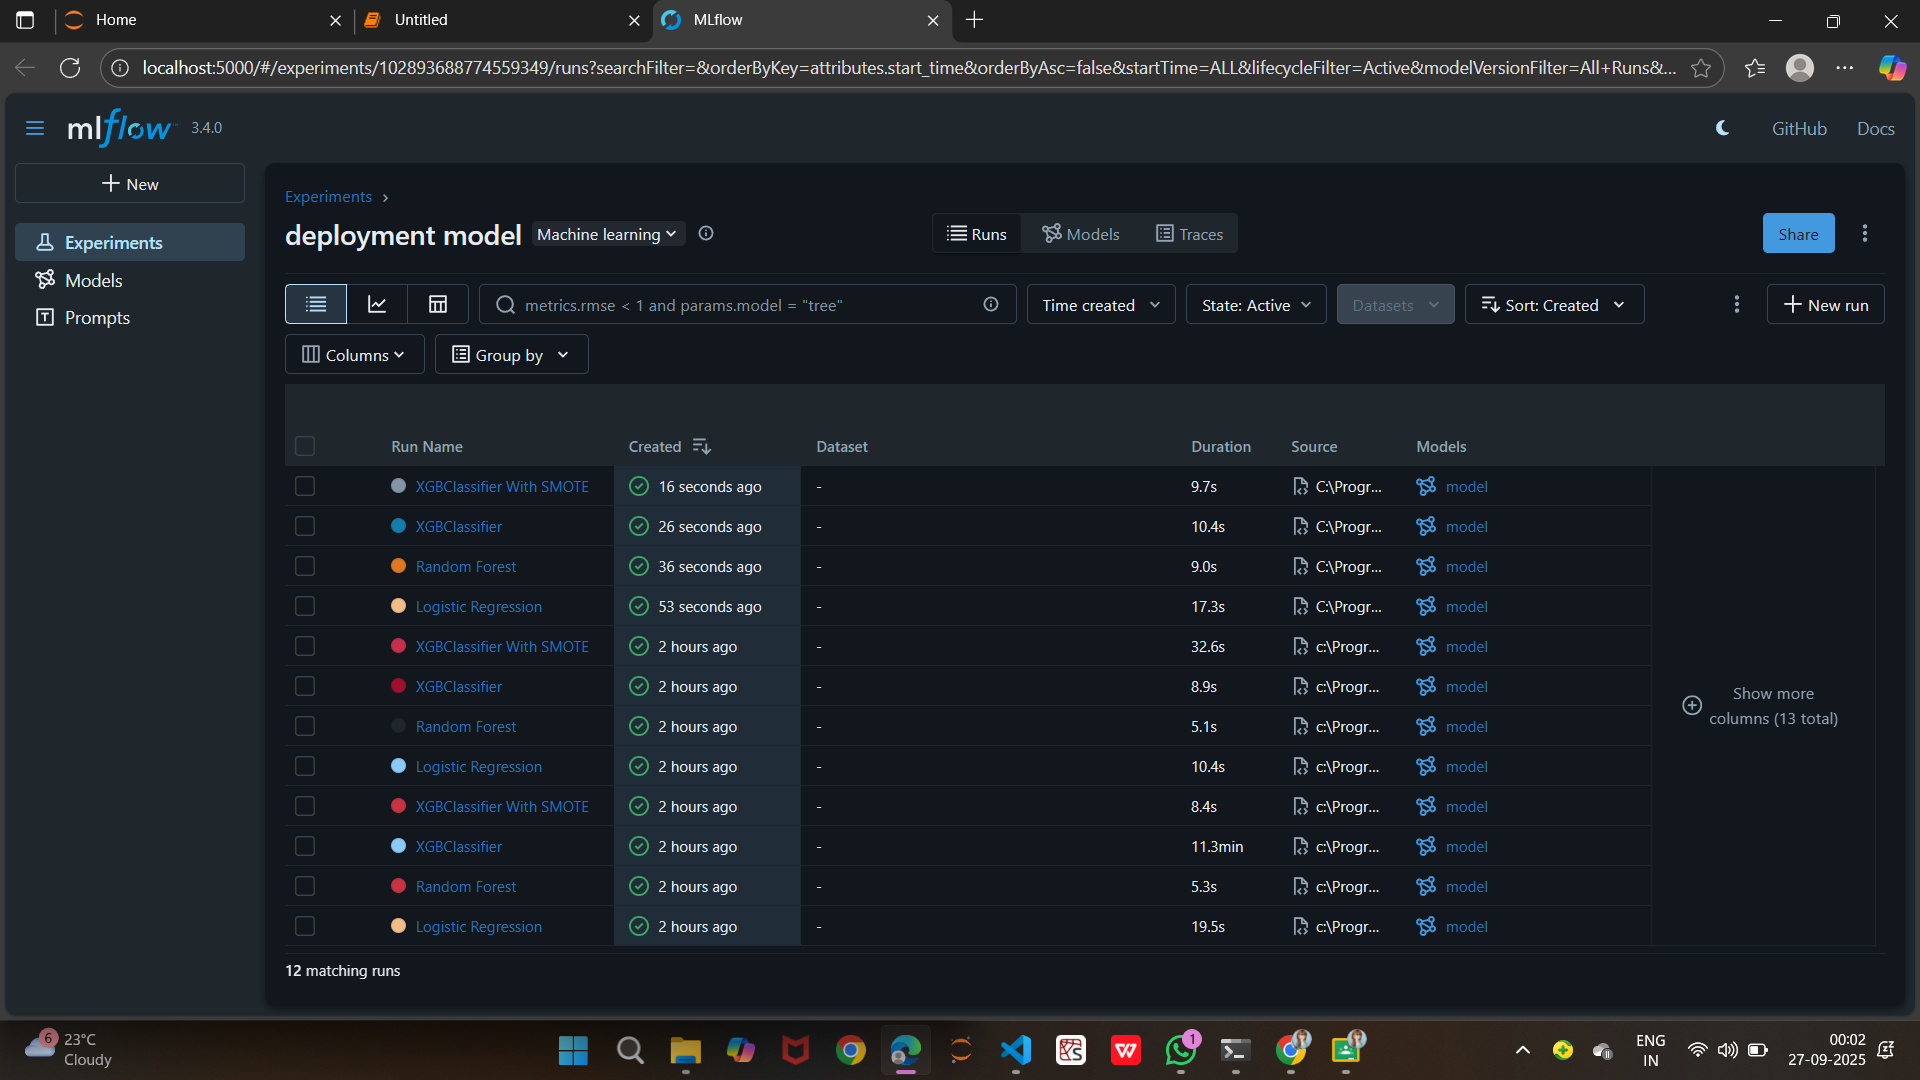

# Register the Model

In [11]:
model_name = 'XGB-Smote'
run_id=input('Please type RunID')
model_uri = f'runs:/{run_id}/model'

with mlflow.start_run(run_id=run_id):
    mlflow.register_model(model_uri=model_uri, name=model_name)

Please type RunID d368e139370d4474824fc22282efee81


Registered model 'XGB-Smote' already exists. Creating a new version of this model...
2025/09/27 00:04:24 WARNING mlflow.tracking._model_registry.fluent: Run with id d368e139370d4474824fc22282efee81 has no artifacts at artifact path 'model', registering model based on models:/m-12c51087d66443de846ec16189d4fb19 instead
2025/09/27 00:04:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGB-Smote, version 4


🏃 View run XGBClassifier at: http://localhost:5000/#/experiments/102893688774559349/runs/d368e139370d4474824fc22282efee81
🧪 View experiment at: http://localhost:5000/#/experiments/102893688774559349


Created version '4' of model 'XGB-Smote'.


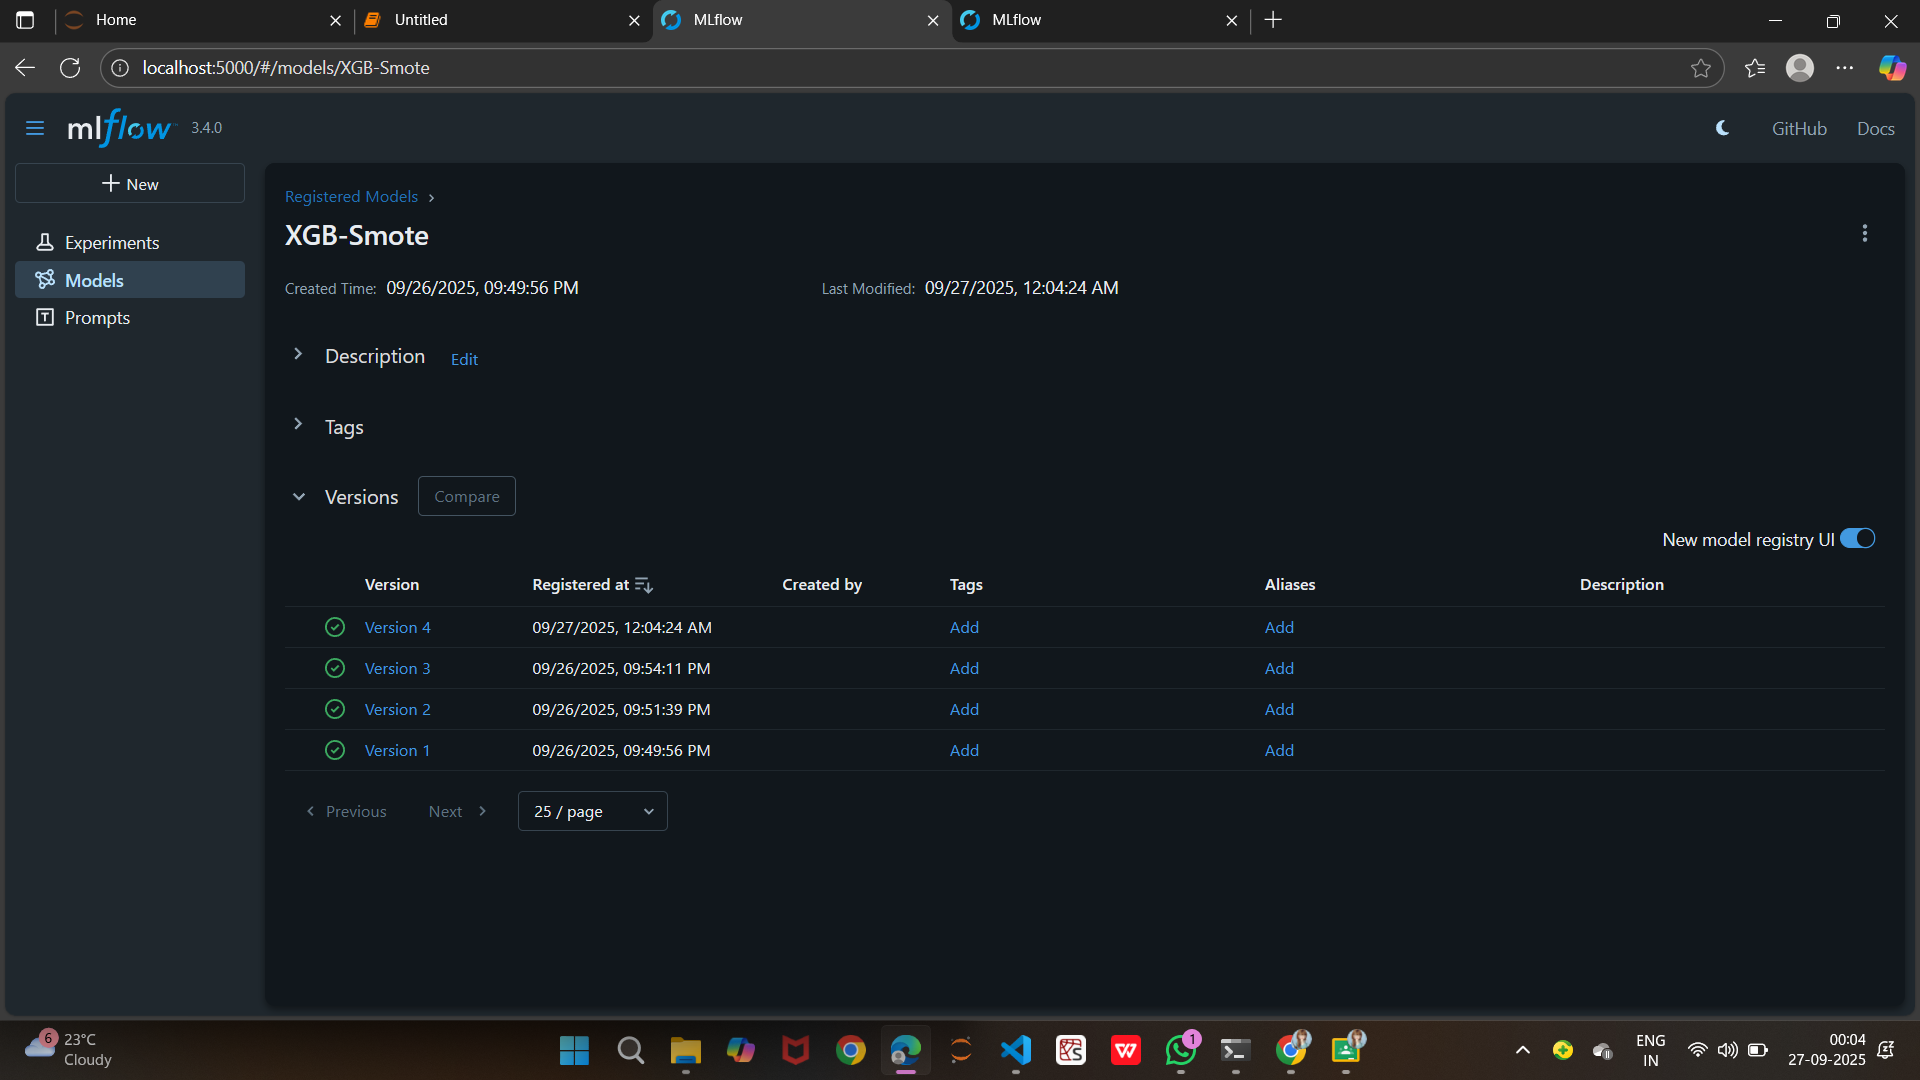

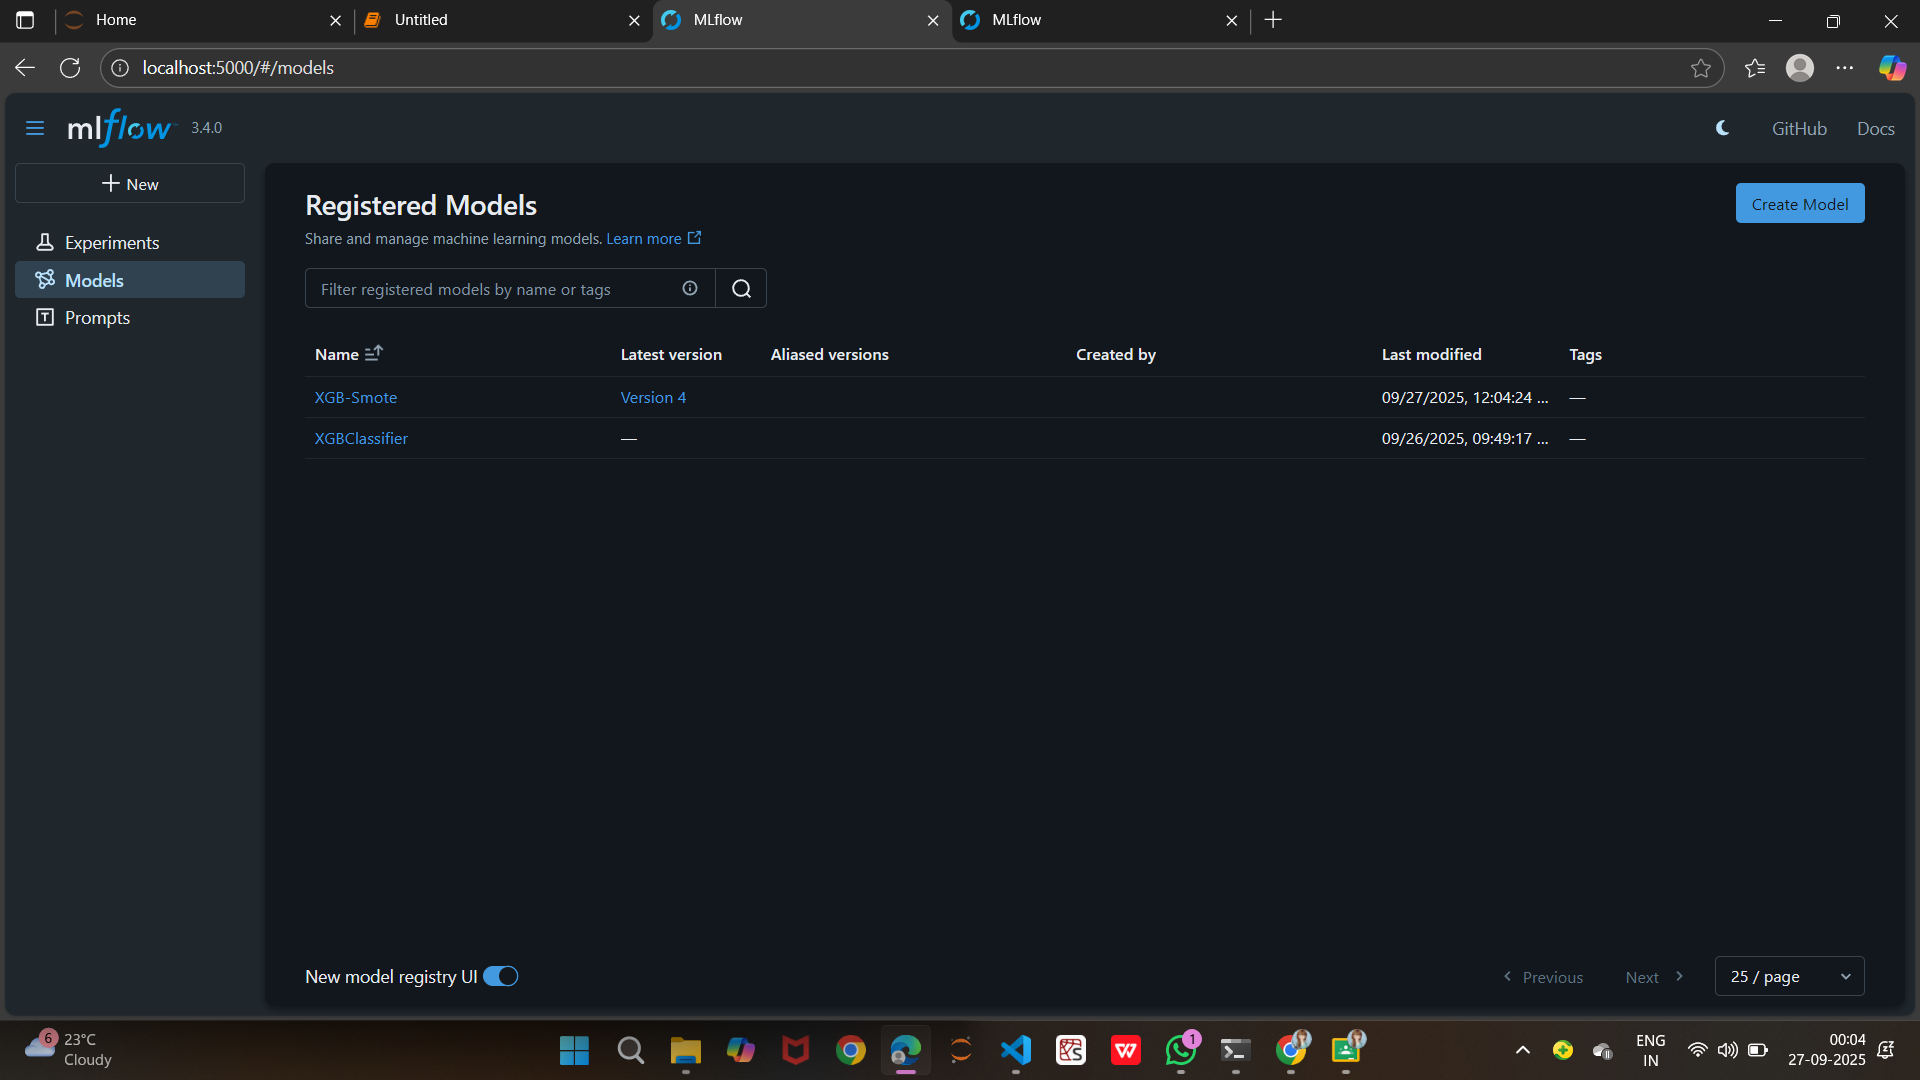

# Load the Model

In [12]:
model_name = 'XGB-Smote'
model_version = 1
model_uri = f"models:/{model_name}/{model_version}"

loaded_model = mlflow.xgboost.load_model(model_uri)
y_pred = loaded_model.predict(X_test)
y_pred[:4]

array([0, 0, 0, 0])